<div align=center> <font color="#3C5BDA" size=8 face="微软雅黑"> Arrival Time Prediction using a Stacked Model </font> </div>

### Table of Contents:
- 1. Import Dependencies
- 2. Exploratory Data Analysis (EDA) and Data Preprocessing
    - Loading and Processing flight_data.csv and JFK NYC LGA Weather.csv
    - Creating, Loading and Processing JFK EWR and LGA Flights.csv
- 3. Data Modeling and Evaluation
    - Creating a XGBoost Regressor
    - Creating a CatBoost Regressor
    - Evaluating the CatBoost and XGBoost Regressor
    - Creating a Stacked Model
    - Evaluating the Stacked Model
- 4. Conclusion

<div align=center> <font color="#3C5BDA" size=6 face="微软雅黑"> 1. Import Dependencies </font> </div>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dropout, Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostRegressor
import xgboost as xgb 
from itertools import product
import regex as re
import optuna
import holidays
from pickle import dump, load
import warnings
warnings.filterwarnings('ignore')

In [8]:
# everything is installed in this codespace

<div align=center> <font color="#3C5BDA" size=6 face="微软雅黑"> 2. EDA and Data Preprocessing </font> </div>

### Loading and Processing flight_data.csv and JFK NYC LGA Weather.csv

In [9]:
flights = pd.read_csv('./data/flight_data.csv')
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,United Airlines,1545,N14228,EWR,IAH,227.0,1400,5,15,1/1/2013 5:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,United Airlines,1714,N24211,LGA,IAH,227.0,1416,5,29,1/1/2013 5:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,American Airlines,1141,N619AA,JFK,MIA,160.0,1089,5,40,1/1/2013 5:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,Jetblue Airways,725,N804JB,JFK,BQN,183.0,1576,5,45,1/1/2013 5:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,Delta Air Lines,461,N668DN,LGA,ATL,116.0,762,6,0,1/1/2013 6:00


In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            336776 non-null  int64  
 1   month           336776 non-null  int64  
 2   day             336776 non-null  int64  
 3   dep_time        328521 non-null  float64
 4   sched_dep_time  336776 non-null  int64  
 5   dep_delay       328521 non-null  float64
 6   arr_time        328063 non-null  float64
 7   sched_arr_time  336776 non-null  int64  
 8   arr_delay       327346 non-null  float64
 9   carrier         336776 non-null  object 
 10  flight          336776 non-null  int64  
 11  tailnum         334264 non-null  object 
 12  origin          336776 non-null  object 
 13  dest            336776 non-null  object 
 14  air_time        327346 non-null  float64
 15  distance        336776 non-null  int64  
 16  hour            336776 non-null  int64  
 17  minute    

In [11]:
flights.carrier.value_counts()

carrier
United Airlines        58665
Jetblue Airways        54635
ExpressJet Airlines    54173
Delta Air Lines        48110
American Airlines      32729
Envoy Air              26397
US Airways             20536
Endeavor Air           18460
Southwest Airlines     12275
Virgin America          5162
AirTran Airways         3260
Alaska Airlines          714
Frontier Airlines        685
Mesa Airlines            601
Hawaiian Airlines        342
SkyWest Airlines          32
Name: count, dtype: int64

In [12]:
flights.carrier.unique()

array(['United Airlines', 'American Airlines', 'Jetblue Airways',
       'Delta Air Lines', 'ExpressJet Airlines', 'Envoy Air',
       'US Airways', 'Southwest Airlines', 'Virgin America',
       'AirTran Airways', 'Alaska Airlines', 'Endeavor Air',
       'Frontier Airlines', 'Hawaiian Airlines', 'Mesa Airlines',
       'SkyWest Airlines'], dtype=object)

In [13]:
flights['carrier'] = flights['carrier'].replace({
    'UA' : 'United Airlines',
    'AA' : 'American Airlines',
    'B6' : 'Jetblue Airways',
    'DL' : 'Delta Air Lines',
    'EV' : 'ExpressJet Airlines',
    'MQ' : 'Envoy Air',
    'US' : 'US Airways',
    'WN' : 'Southwest Airlines',
    'VX' : 'Virgin America',
    'FL' : 'AirTran Airways',
    'AS' : 'Alaska Airlines',
    '9E' : 'Endeavor Air',
    'F9' : 'Frontier Airlines',
    'HA' : 'Hawaiian Airlines',
    'YV' : 'Mesa Airlines',
    'OO' : 'SkyWest Airlines'
})

In [14]:
flights.carrier.unique()

array(['United Airlines', 'American Airlines', 'Jetblue Airways',
       'Delta Air Lines', 'ExpressJet Airlines', 'Envoy Air',
       'US Airways', 'Southwest Airlines', 'Virgin America',
       'AirTran Airways', 'Alaska Airlines', 'Endeavor Air',
       'Frontier Airlines', 'Hawaiian Airlines', 'Mesa Airlines',
       'SkyWest Airlines'], dtype=object)

In [15]:
# to ensure you can see all of its columns, even if there are a large number of them. 
# This is particularly useful when working with wide DataFrames having many columns.
pd.set_option('display.max_columns', None)

In [16]:
weather = pd.read_csv('./data/JFK NYC LGA Weather.csv')
weather.head()

,station,valid,lon,lat,elevation,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,NYC,2013-01-01 00:51,-73.9693,40.779,27.0,39.0,24.1,54.77,260.0,9.0,0.0,29.89,1011.4,10.0,19.0,OVC,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.22,KNYC 010551Z AUTO 26009G19KT 230V300 10SM OVC1...,NaN
1,NYC,2013-01-01 01:51,-73.9693,40.779,27.0,38.0,26.0,61.94,NaN,3.0,0.0,29.90,1011.7,10.0,15.0,OVC,NaN,NaN,NaN,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.48,KNYC 010651Z AUTO VRB03G15KT 10SM OVC060 03/M0...,NaN
2,NYC,2013-01-01 02:51,-73.9693,40.779,27.0,39.0,27.0,61.63,NaN,6.0,0.0,29.90,1011.6,10.0,NaN,OVC,NaN,NaN,NaN,4800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.98,KNYC 010751Z AUTO VRB06KT 10SM OVC048 04/M03 A...,NaN
3,NYC,2013-01-01 03:51,-73.9693,40.779,27.0,39.0,27.0,61.63,260.0,8.0,0.0,29.91,1011.9,10.0,NaN,OVC,NaN,NaN,NaN,4600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.76,KNYC 010851Z AUTO 26008KT 210V310 10SM OVC046 ...,NaN
4,NYC,2013-01-01 04:51,-73.9693,40.779,27.0,39.0,27.0,61.63,NaN,6.0,0.0,29.90,1011.6,10.0,NaN,OVC,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.98,KNYC 010951Z AUTO VRB06KT 10SM OVC050 04/M03 A...,NaN


In [17]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30661 entries, 0 to 30660
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station            30661 non-null  object 
 1   valid              30661 non-null  object 
 2   lon                30661 non-null  float64
 3   lat                30661 non-null  float64
 4   elevation          30661 non-null  float64
 5   tmpf               30659 non-null  float64
 6   dwpf               30659 non-null  float64
 7   relh               30659 non-null  float64
 8   drct               26291 non-null  float64
 9   sknt               30047 non-null  float64
 10  p01i               28319 non-null  float64
 11  alti               30660 non-null  float64
 12  mslp               26109 non-null  float64
 13  vsby               30661 non-null  float64
 14  gust               6113 non-null   float64
 15  skyc1              30653 non-null  object 
 16  skyc2              137

In [18]:
weather.isnull().sum()

station                  0
valid                    0
lon                      0
lat                      0
elevation                0
tmpf                     2
dwpf                     2
relh                     2
drct                  4370
sknt                   614
p01i                  2342
alti                     1
mslp                  4552
vsby                     0
gust                 24548
skyc1                    8
skyc2                16951
skyc3                24337
skyc4                29445
skyl1                 6026
skyl2                16951
skyl3                24337
skyl4                29445
wxcodes              23875
ice_accretion_1hr    30640
ice_accretion_3hr    30658
ice_accretion_6hr    30655
peak_wind_gust       28835
peak_wind_drct       28835
peak_wind_time       28835
feel                   204
metar                    0
snowdepth            30654
dtype: int64

In [19]:
weather.skyc1.unique()

array(['OVC', 'BKN', 'FEW', 'SCT', 'CLR', 'VV ', nan], dtype=object)

In [20]:
# 将 weather DataFrame 中 valid 列的数据，基于空格分割成两部分，并分别创建两个新列 date 和 time 来存储这些分割后的数据。
weather['date'], weather['time'] = weather['valid'].str.split(' ', expand=True)[0], weather['valid'].str.split(' ', expand=True)[1]

In [21]:
weather[(weather['date'] == '2013-01-01')]['time'].unique()

array(['00:51', '01:51', '02:51', '03:51', '04:51', '05:51', '06:51',
       '07:51', '08:51', '09:51', '10:51', '11:51', '12:51', '13:51',
       '14:51', '15:51', '16:51', '17:51', '18:51', '19:51', '20:51',
       '21:51', '22:51', '23:51', '12:18', '13:02'], dtype=object)

In [22]:
weather[(weather['date'] == '2013-01-01') & (weather['time'] == '07:51')]

,station,valid,lon,lat,elevation,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth,date,time
7,NYC,2013-01-01 07:51,-73.9693,40.7790,27.0,38.0,27.0,64.29,260.0,6.0,0.0,29.90,1011.7,10.0,NaN,OVC,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.68,KNYC 011251Z AUTO 26006KT 10SM OVC050 03/M03 A...,NaN,2013-01-01,07:51
10682,LGA,2013-01-01 07:51,-73.8803,40.7794,9.0,40.0,26.0,57.33,250.0,13.0,0.0,29.88,1011.9,10.0,22.0,BKN,BKN,BKN,NaN,5000.0,9000.0,26000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.71,KLGA 011251Z 25013G22KT 10SM BKN050 BKN090 BKN...,NaN,2013-01-01,07:51
20859,JFK,2013-01-01 07:51,-73.7622,40.6386,7.0,39.0,28.0,64.43,260.0,12.0,0.0,29.90,1012.5,10.0,NaN,BKN,BKN,OVC,NaN,5000.0,9000.0,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.94,KJFK 011251Z 26012KT 10SM BKN050 BKN090 OVC250...,NaN,2013-01-01,07:51


In [23]:
flights[(flights['origin'] == 'EWR') & (flights['dest'] == 'IAH')]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,United Airlines,1545,N14228,EWR,IAH,227.0,1400,5,15,1/1/2013 5:00
89,2013,1,1,739.0,739,0.0,1104.0,1038,26.0,United Airlines,1479,N37408,EWR,IAH,249.0,1400,7,39,1/1/2013 7:00
177,2013,1,1,908.0,908,0.0,1228.0,1219,9.0,United Airlines,1220,N12216,EWR,IAH,233.0,1400,9,8,1/1/2013 9:00
247,2013,1,1,1044.0,1045,-1.0,1352.0,1351,1.0,United Airlines,455,N667UA,EWR,IAH,229.0,1400,10,45,1/1/2013 10:00
311,2013,1,1,1205.0,1200,5.0,1503.0,1505,-2.0,United Airlines,1461,N39418,EWR,IAH,221.0,1400,12,0,1/1/2013 12:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336406,2013,9,30,1551.0,1521,30.0,1825.0,1807,18.0,United Airlines,404,N538UA,EWR,IAH,190.0,1400,15,21,30-09-2013 15:00
336448,2013,9,30,1623.0,1629,-6.0,1852.0,1919,-27.0,United Airlines,1695,N34131,EWR,IAH,177.0,1400,16,29,30-09-2013 16:00
336524,2013,9,30,1729.0,1720,9.0,2001.0,2010,-9.0,United Airlines,652,N455UA,EWR,IAH,173.0,1400,17,20,30-09-2013 17:00
336694,2013,9,30,2015.0,2015,0.0,2244.0,2307,-23.0,United Airlines,1545,N17730,EWR,IAH,174.0,1400,20,15,30-09-2013 20:00


In [24]:
weather['p01i'].dropna()[weather['p01i'] != 0]

261      0.02
262      0.03
263      0.05
264      0.06
265      0.04
         ... 
30621    0.21
30622    0.34
30623    0.27
30624    0.05
30625    0.05
Name: p01i, Length: 3305, dtype: float64

In [25]:
weather['vsby']

0        10.0
1        10.0
2        10.0
3        10.0
4        10.0
         ... 
30656    10.0
30657    10.0
30658    10.0
30659    10.0
30660    10.0
Name: vsby, Length: 30661, dtype: float64

In [26]:
flights.origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [27]:
# 计算 flights 数据集中，按航空承运商 (carrier) 分组的航班平均到达延误时间，并将结果四舍五入到小数点后两位。
round(flights.groupby('carrier')['arr_delay'].mean(), 2)

carrier
AirTran Airways        20.12
Alaska Airlines        -9.93
American Airlines       0.36
Delta Air Lines         1.64
Endeavor Air            7.38
Envoy Air              10.77
ExpressJet Airlines    15.80
Frontier Airlines      21.92
Hawaiian Airlines      -6.92
Jetblue Airways         9.46
Mesa Airlines          15.56
SkyWest Airlines       11.93
Southwest Airlines      9.65
US Airways              2.13
United Airlines         3.56
Virgin America          1.76
Name: arr_delay, dtype: float64

In [28]:
round(flights.groupby('carrier')['dep_delay'].mean(), 2)

carrier
AirTran Airways        18.73
Alaska Airlines         5.80
American Airlines       8.59
Delta Air Lines         9.26
Endeavor Air           16.73
Envoy Air              10.55
ExpressJet Airlines    19.96
Frontier Airlines      20.22
Hawaiian Airlines       4.90
Jetblue Airways        13.02
Mesa Airlines          19.00
SkyWest Airlines       12.59
Southwest Airlines     17.71
US Airways              3.78
United Airlines        12.11
Virgin America         12.87
Name: dep_delay, dtype: float64

In [29]:
round(flights.groupby('carrier')['air_time'].mean(), 0)

carrier
AirTran Airways        101.0
Alaska Airlines        326.0
American Airlines      189.0
Delta Air Lines        174.0
Endeavor Air            87.0
Envoy Air               91.0
ExpressJet Airlines     90.0
Frontier Airlines      230.0
Hawaiian Airlines      623.0
Jetblue Airways        151.0
Mesa Airlines           66.0
SkyWest Airlines        83.0
Southwest Airlines     148.0
US Airways              89.0
United Airlines        212.0
Virgin America         337.0
Name: air_time, dtype: float64

In [30]:
round(flights.groupby('carrier')['arr_time'].mean(), 0)

carrier
AirTran Airways        1574.0
Alaska Airlines        1565.0
American Airlines      1521.0
Delta Air Lines        1573.0
Endeavor Air           1639.0
Envoy Air              1551.0
ExpressJet Airlines    1488.0
Frontier Airlines      1672.0
Hawaiian Airlines      1474.0
Jetblue Airways        1406.0
Mesa Airlines          1761.0
SkyWest Airlines       1913.0
Southwest Airlines     1443.0
US Airways             1402.0
United Airlines        1509.0
Virgin America         1523.0
Name: arr_time, dtype: float64

In [31]:
flights['month'].unique()

array([ 1, 10, 11, 12,  2,  3,  4,  5,  6,  7,  8,  9])

In [32]:
flights.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [33]:
weather = weather[['station', 'date', 'time', 'tmpf', 'relh', 'skyc1', 'vsby']]

In [34]:
weather.head()

,station,date,time,tmpf,relh,skyc1,vsby
0,NYC,2013-01-01,00:51,39.0,54.77,OVC,10.0
1,NYC,2013-01-01,01:51,38.0,61.94,OVC,10.0
2,NYC,2013-01-01,02:51,39.0,61.63,OVC,10.0
3,NYC,2013-01-01,03:51,39.0,61.63,OVC,10.0
4,NYC,2013-01-01,04:51,39.0,61.63,OVC,10.0


In [35]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30661 entries, 0 to 30660
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  30661 non-null  object 
 1   date     30661 non-null  object 
 2   time     30661 non-null  object 
 3   tmpf     30659 non-null  float64
 4   relh     30659 non-null  float64
 5   skyc1    30653 non-null  object 
 6   vsby     30661 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.6+ MB


In [36]:
weather.isnull().sum()


station    0
date       0
time       0
tmpf       2
relh       2
skyc1      8
vsby       0
dtype: int64

In [37]:
weather['tmpf'] = weather['tmpf'].fillna(round(weather['tmpf'].mean()))
weather['relh'] = weather['relh'].fillna(round(weather['relh'].mean(), 2))
weather['skyc1'] = weather['skyc1'].fillna(weather['skyc1'].mode()[0])

In [38]:
weather.isnull().sum()

station    0
date       0
time       0
tmpf       0
relh       0
skyc1      0
vsby       0
dtype: int64

In [39]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,United Airlines,1545,N14228,EWR,IAH,227.0,1400,5,15,1/1/2013 5:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,United Airlines,1714,N24211,LGA,IAH,227.0,1416,5,29,1/1/2013 5:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,American Airlines,1141,N619AA,JFK,MIA,160.0,1089,5,40,1/1/2013 5:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,Jetblue Airways,725,N804JB,JFK,BQN,183.0,1576,5,45,1/1/2013 5:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,Delta Air Lines,461,N668DN,LGA,ATL,116.0,762,6,0,1/1/2013 6:00


In [40]:
flights['time'] = flights['time_hour'].str.split(' ', expand=True)[1]

In [41]:
flights['time']

0          5:00
1          5:00
2          5:00
3          5:00
4          6:00
          ...  
336771    14:00
336772    22:00
336773    12:00
336774    11:00
336775    08:00
Name: time, Length: 336776, dtype: object

In [43]:
def revise_time_format(record):
    record['time'] = "{:02d}:{:02d}".format(int(record['time'].split(':')[0]), int(record['time'].split(':')[1]))
    return record

flights = flights.apply(revise_time_format, axis=1)
flights

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,time
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,United Airlines,1545,N14228,EWR,IAH,227.0,1400,5,15,1/1/2013 5:00,05:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,United Airlines,1714,N24211,LGA,IAH,227.0,1416,5,29,1/1/2013 5:00,05:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,American Airlines,1141,N619AA,JFK,MIA,160.0,1089,5,40,1/1/2013 5:00,05:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,Jetblue Airways,725,N804JB,JFK,BQN,183.0,1576,5,45,1/1/2013 5:00,05:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,Delta Air Lines,461,N668DN,LGA,ATL,116.0,762,6,0,1/1/2013 6:00,06:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,Endeavor Air,3393,NaN,JFK,DCA,NaN,213,14,55,30-09-2013 14:00,14:00
336772,2013,9,30,NaN,2200,NaN,NaN,2312,NaN,Endeavor Air,3525,NaN,LGA,SYR,NaN,198,22,0,30-09-2013 22:00,22:00
336773,2013,9,30,NaN,1210,NaN,NaN,1330,NaN,Envoy Air,3461,N535MQ,LGA,BNA,NaN,764,12,10,30-09-2013 12:00,12:00
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,Envoy Air,3572,N511MQ,LGA,CLE,NaN,419,11,59,30-09-2013 11:00,11:00


In [44]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            336776 non-null  int64  
 1   month           336776 non-null  int64  
 2   day             336776 non-null  int64  
 3   dep_time        328521 non-null  float64
 4   sched_dep_time  336776 non-null  int64  
 5   dep_delay       328521 non-null  float64
 6   arr_time        328063 non-null  float64
 7   sched_arr_time  336776 non-null  int64  
 8   arr_delay       327346 non-null  float64
 9   carrier         336776 non-null  object 
 10  flight          336776 non-null  int64  
 11  tailnum         334264 non-null  object 
 12  origin          336776 non-null  object 
 13  dest            336776 non-null  object 
 14  air_time        327346 non-null  float64
 15  distance        336776 non-null  int64  
 16  hour            336776 non-null  int64  
 17  minute    

In [45]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30661 entries, 0 to 30660
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  30661 non-null  object 
 1   date     30661 non-null  object 
 2   time     30661 non-null  object 
 3   tmpf     30661 non-null  float64
 4   relh     30661 non-null  float64
 5   skyc1    30661 non-null  object 
 6   vsby     30661 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.6+ MB


In [46]:
weather[(weather['time'] == '20:51') & (weather['date'] == '2013-07-23') & (weather['station'] == 'NYC')]

,station,date,time,tmpf,relh,skyc1,vsby
6083,NYC,2013-07-23,20:51,80.0,69.23,SCT,10.0


In [47]:
flights.dep_time.describe()

count    328521.000000
mean       1349.109947
std         488.281791
min           1.000000
25%         907.000000
50%        1401.000000
75%        1744.000000
max        2400.000000
Name: dep_time, dtype: float64

In [48]:
def revise_date_format(record):
    date, time = record['time_hour'].split(' ')[0], record['time_hour'].split(' ')[1]
    date = pd.to_datetime(date)
    record['date'] = '{:04d}-{:02d}-{:02d}'.format(date.year, date.month, date.day)
    return record

flights = flights.apply(revise_date_format, axis=1)

In [49]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,time,date
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,United Airlines,1545,N14228,EWR,IAH,227.0,1400,5,15,1/1/2013 5:00,05:00,2013-01-01
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,United Airlines,1714,N24211,LGA,IAH,227.0,1416,5,29,1/1/2013 5:00,05:00,2013-01-01
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,American Airlines,1141,N619AA,JFK,MIA,160.0,1089,5,40,1/1/2013 5:00,05:00,2013-01-01
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,Jetblue Airways,725,N804JB,JFK,BQN,183.0,1576,5,45,1/1/2013 5:00,05:00,2013-01-01
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,Delta Air Lines,461,N668DN,LGA,ATL,116.0,762,6,0,1/1/2013 6:00,06:00,2013-01-01


In [50]:
flights['date'].max()

'2013-12-31'

In [51]:
df = flights[(flights['dep_time'] == 2100.0) & (flights['origin'] == 'EWR')]
df[df['date'].duplicated()]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,time,date
38989,2013,10,13,2100.0,2110,-10.0,2325.0,2341,-16.0,ExpressJet Airlines,5811,N14902,EWR,JAX,115.0,820,21,10,13-10-2013 21:00,21:00,2013-10-13
67860,2013,11,13,2100.0,2105,-5.0,2338.0,11,-33.0,United Airlines,1682,N36476,EWR,FLL,141.0,1065,21,5,13-11-2013 21:00,21:00,2013-11-13
68852,2013,11,14,2100.0,2105,-5.0,2352.0,11,-19.0,United Airlines,1682,N37466,EWR,FLL,147.0,1065,21,5,14-11-2013 21:00,21:00,2013-11-14
99769,2013,12,18,2100.0,2100,0.0,2158.0,2206,-8.0,United Airlines,994,N411UA,EWR,BOS,41.0,200,21,0,18-12-2013 21:00,21:00,2013-12-18
114595,2013,2,4,2100.0,2045,15.0,2203.0,2153,10.0,Jetblue Airways,1178,N334JB,EWR,BOS,44.0,200,20,45,4/2/2013 20:00,20:00,2013-04-02
139794,2013,3,4,2100.0,2115,-15.0,2326.0,2358,-32.0,Jetblue Airways,927,N630JB,EWR,MCO,128.0,937,21,15,4/3/2013 21:00,21:00,2013-04-03
170728,2013,4,6,2100.0,2100,0.0,14.0,32,-18.0,United Airlines,1644,N76515,EWR,SFO,359.0,2565,21,0,6/4/2013 21:00,21:00,2013-06-04
171625,2013,4,7,2100.0,2105,-5.0,2306.0,2259,7.0,ExpressJet Airlines,4700,N27152,EWR,CLT,83.0,529,21,5,7/4/2013 21:00,21:00,2013-07-04
175491,2013,4,11,2100.0,1908,112.0,2231.0,2051,100.0,United Airlines,1482,N15710,EWR,ORD,123.0,719,19,8,11/4/2013 19:00,19:00,2013-11-04
178232,2013,4,14,2100.0,2100,0.0,2236.0,2229,7.0,ExpressJet Airlines,4641,N13538,EWR,MKE,114.0,725,21,0,14-04-2013 21:00,21:00,2013-04-14


这段代码是用Python编写的，用于从名为 `flights` 的DataFrame中筛选数据。让我们来详细解释代码的每个部分：

1. `df = flights[(flights['dep_time'] == 2100.0) & (flights['origin'] == 'EWR')]`:
   - `flights`: 这是要进行数据筛选的DataFrame的名称。
   - `flights['dep_time'] == 2100.0`: 这是一个条件，用于选择出发时间（`dep_time`）恰好为2100.0的行，这可能代表的是HHMM格式的时间（晚上9点）。
   - `flights['origin'] == 'EWR'`: 这是另一个条件，用于选择起始地为'EWR'的行。'EWR' 可能是一个机场代码，很可能代表的是纽瓦克自由国际机场。
   - `&`: 这是一个逻辑与操作符。它将两个条件结合起来，所以只有同时满足两个条件（即出发时间为2100.0且起始地为'EWR'）的行才会被选中。
   - 筛选的结果然后赋值给一个新的DataFrame `df`。

2. `df[df['date'].duplicated()]`:
   - `df['date'].duplicated()`: 这部分代码检查 `df` DataFrame中的日期是否有重复。`.duplicated()` 方法返回一个布尔值序列，如果相应的值是重复的（即它在序列中前面已经出现过），则为 `True`。
   - `df[...]`: 外层的 `df[...]` 使用布尔序列来筛选DataFrame `df`。它只选择日期值为重复的行。

总的来说，这段代码首先筛选 `flights` DataFrame以获取晚上9点从纽瓦克机场出发的航班，然后进一步筛选这个子集，找出日期不唯一（即在这个子集中有相同日期的其他航班）的行。

In [52]:
weather['station'] = weather['station'].replace({'NYC' : 'EWR'})

In [53]:
flights[(flights['dep_time'] == 2100.0) & (flights['date'] == '2013-07-23') & (flights['origin'] == 'EWR')]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,time,date
271939,2013,7,23,2100.0,2059,1.0,2300.0,2312,-12.0,ExpressJet Airlines,4370,N11106,EWR,CHS,87.0,628,20,59,23-07-2013 20:00,20:00,2013-07-23
271940,2013,7,23,2100.0,1829,151.0,2249.0,2033,136.0,US Airways,1973,N538UW,EWR,CLT,80.0,529,18,29,23-07-2013 18:00,18:00,2013-07-23
271942,2013,7,23,2100.0,2057,3.0,2342.0,2359,-17.0,United Airlines,1241,N33292,EWR,TPA,137.0,997,20,57,23-07-2013 20:00,20:00,2013-07-23


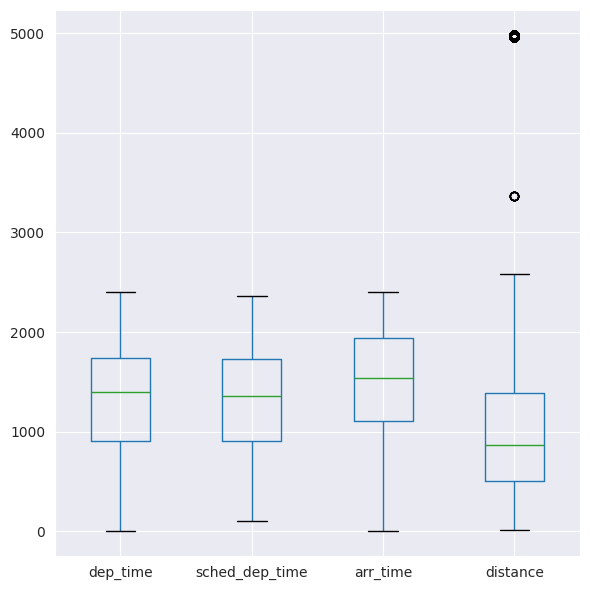

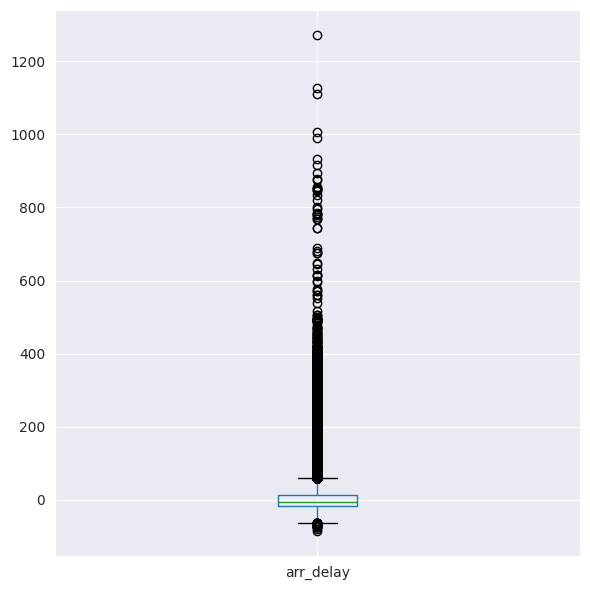

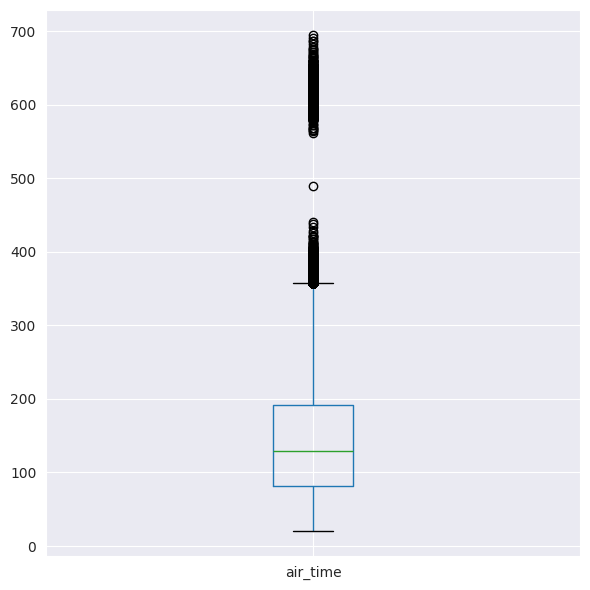

In [54]:
def show_whisker_plot(df):
    plt.figure(figsize=(6, 6))
    df.boxplot();
    plt.tight_layout();
    
show_whisker_plot(flights[['dep_time', 'sched_dep_time', 'arr_time', 'distance']])
show_whisker_plot(flights[['arr_delay']])
show_whisker_plot(flights[['air_time']])

这段代码定义了一个函数 `show_whisker_plot`，用于显示一个DataFrame中数据的箱须图（也称为盒形图），并且实际上使用这个函数来显示不同列的箱须图。下面是对每个部分的详细解释：

1. `def show_whisker_plot(df):`
   - 这行代码定义了一个名为 `show_whisker_plot` 的函数，该函数接受一个参数 `df`，这个参数预期是一个DataFrame。

2. `plt.figure(figsize=(6, 6))`
   - 这行代码使用 `matplotlib.pyplot` 模块（通常缩写为 `plt`）创建一个新的图形。`figsize=(6, 6)` 设置了图形的大小，这里是6英寸宽和6英寸高。

3. `df.boxplot();`
   - 这行代码创建了一个箱须图，用于显示传入DataFrame `df` 的数据。箱须图是一种用于显示数据分布的标准化方式，它可以显示数据的最小值、第一四分位数（Q1）、中位数、第三四分位数（Q3）和最大值，以及可能的异常值。

4. `plt.tight_layout();`
   - 这行代码调整子图参数，以确保图形的布局紧凑，不会有重叠的部分。

5. 使用函数：
   - `show_whisker_plot(flights[['dep_time', 'sched_dep_time', 'arr_time', 'distance']])`: 这行代码使用 `show_whisker_plot` 函数来显示 `flights` DataFrame中 `dep_time`（实际出发时间）、`sched_dep_time`（计划出发时间）、`arr_time`（到达时间）和 `distance`（距离）列的箱须图。
   - `show_whisker_plot(flights[['arr_delay']])`: 这行代码使用同一函数显示 `flights` DataFrame中 `arr_delay`（到达延迟）列的箱须图。
   - `show_whisker_plot(flights[['air_time']])`: 这行代码最后用于显示 `flights` DataFrame中 `air_time`（飞行时间）列的箱须图。

总之，这段代码的目的是创建一个函数来方便地生成并显示DataFrame中特定列的箱须图，并且实际上展示了如何使用这个函数来查看不同航班数据属性的分布情况。